In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq
from math import sqrt, log, exp, pi

In [2]:
from google.colab import files
uploaded = files.upload()

KeyboardInterrupt: 

In [3]:
start_dt = '2024-01-01'
end_dt = '2024-11-30'

bank_symbols = ['SBIN.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'AXISBANK.NS', 'KOTAKBANK.NS']

def bank_data(symbol, start_dt, end_dt):
    stock_data = yf.download(symbol, start=start_dt, end=end_dt)
    return stock_data

for symbol in bank_symbols:
    stock_data = bank_data(symbol, start_dt, end_dt)
    stock_data.dropna(inplace = True)
    returns = stock_data.pct_change()
    #print(yf.Ticker(symbol).options) or option_chain
    #print(stock_data, returns)

/tmp/ipython-input-3-3866860305.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_dt, end=end_dt)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3-3866860305.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_dt, end=end_dt)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3-3866860305.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_dt, end=end_dt)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3-3866860305.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_dt, end=end_dt)
[*********************100%***********************]  1 of 1 completed
/tmp/ipy

In [4]:
def bsm(S, K, r, t, sigma):
    d1 = 1 / (sigma * sqrt(t)) * ( log(S/K) + (r + sigma**2/2) * t)
    d2 = d1 - sigma * sqrt(t)
    c = norm.cdf(d1) * S - norm.cdf(d2) * K * exp(-r * t)
    vega = S*norm.pdf(d1, 0, 1)*np.sqrt(t)
    return c

In [5]:
def implied_vol(S0, K, T, r, market_price):
    try:
      def f(sigma):
        return bsm(S0, K, T, r, sigma) - market_price
      implied_vol = brentq(f, 1e-10, 2)
      return implied_vol
    except ValueError:
      return np.nan

In [6]:
sheet = ['/content/SBI.xlsx', '/content/HDFC.xlsx', '/content/ICICI.xlsx', '/content/AXIS.xlsx', '/content/KOTAK.xlsx']
bank_data = {}
for symbol in sheet:
  data = pd.read_excel(symbol)
  print(data)
  data.columns = data.columns.str.strip()
  data['Date'] = pd.to_datetime(data['Date'], format='%d-%b-%y')
  data['Expiry'] = pd.to_datetime(data['Expiry'], format='%d-%b-%y')
  data['ATM_Diff'] = abs(data['Strike Price'] - data['Underlying Value'])
  data = data.loc[data.groupby('Date')['ATM_Diff'].idxmin()]
  data = data.drop(columns=['ATM_Diff'])
  data['T'] = (data['Expiry'] - data['Date']).dt.days
  data['T'] = data['T']/365
  print(data)
  bank_data[symbol] = data

FileNotFoundError: [Errno 2] No such file or directory: '/content/SBI.xlsx'

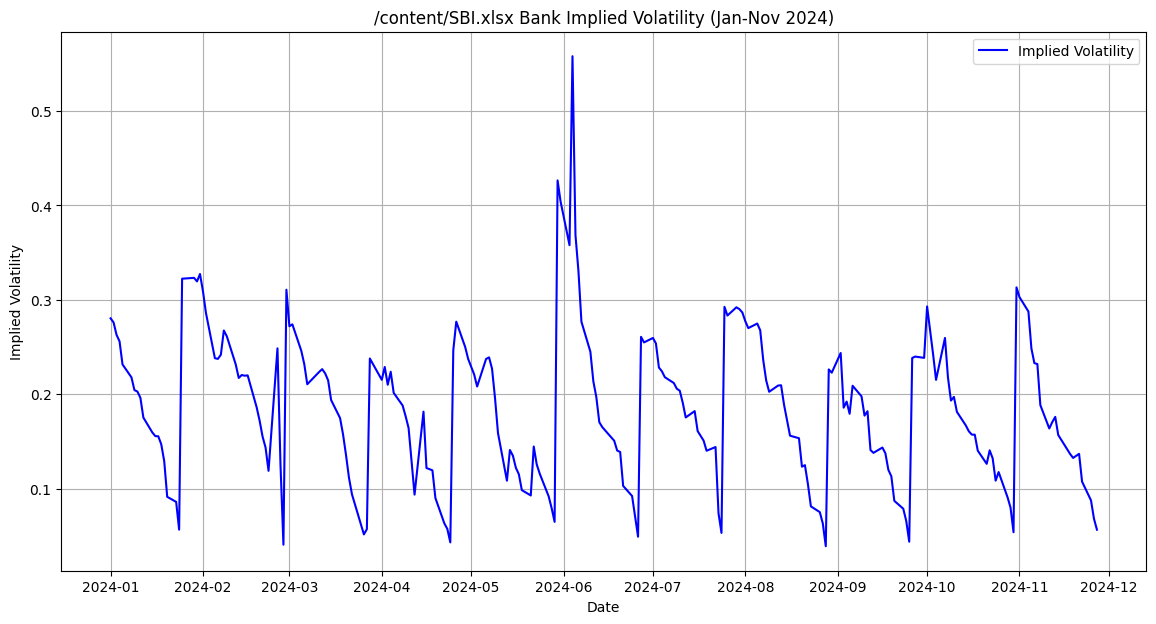

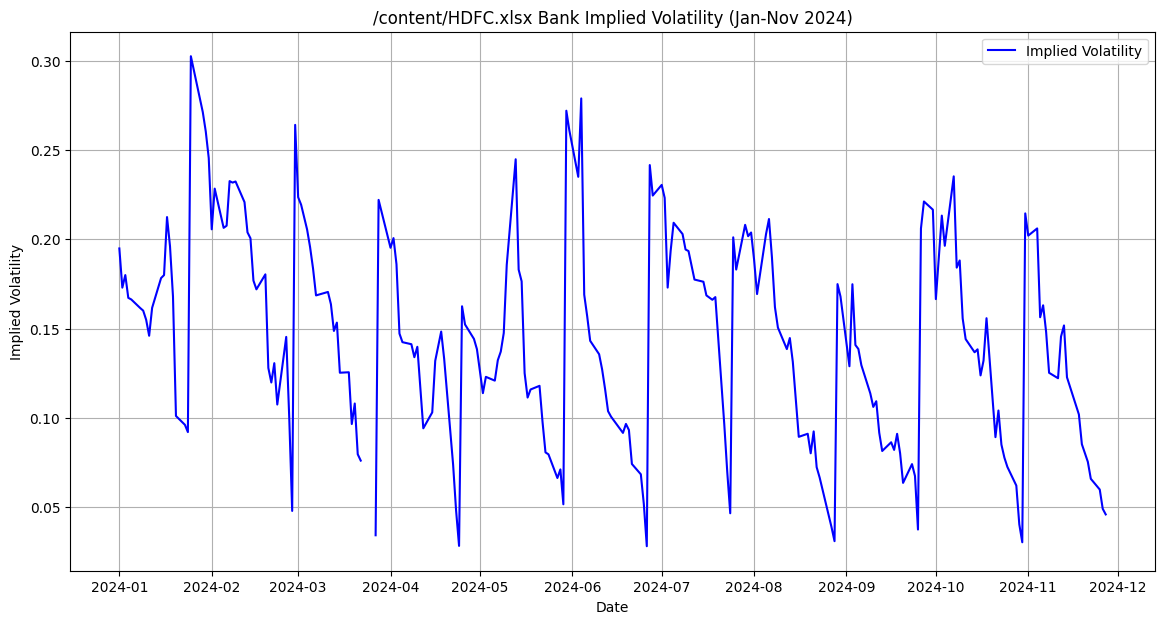

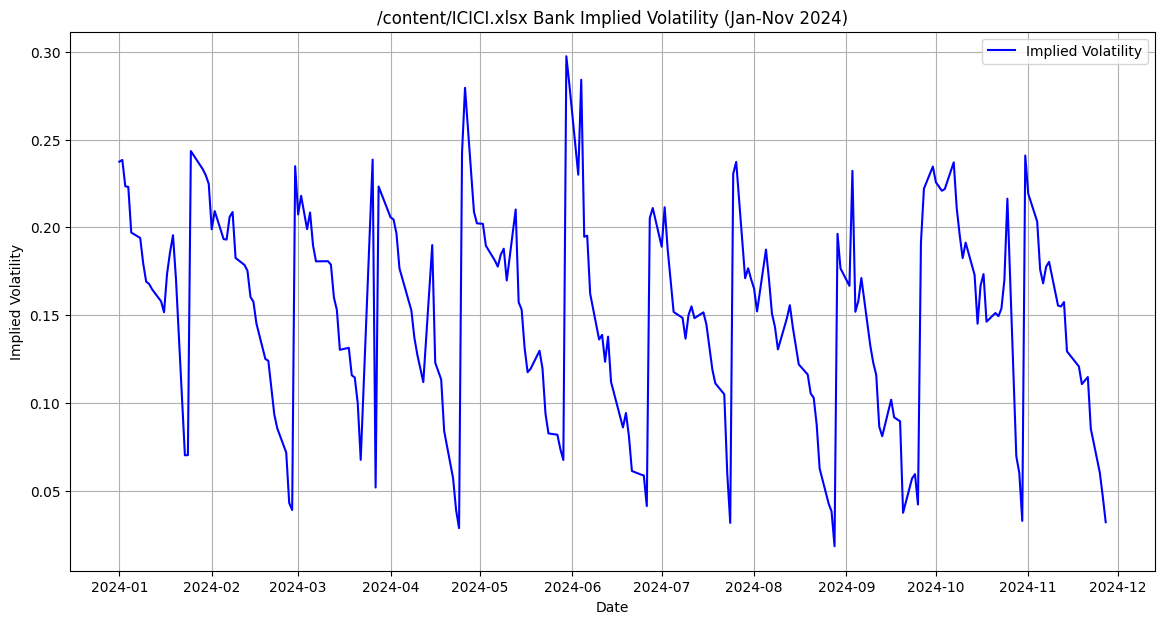

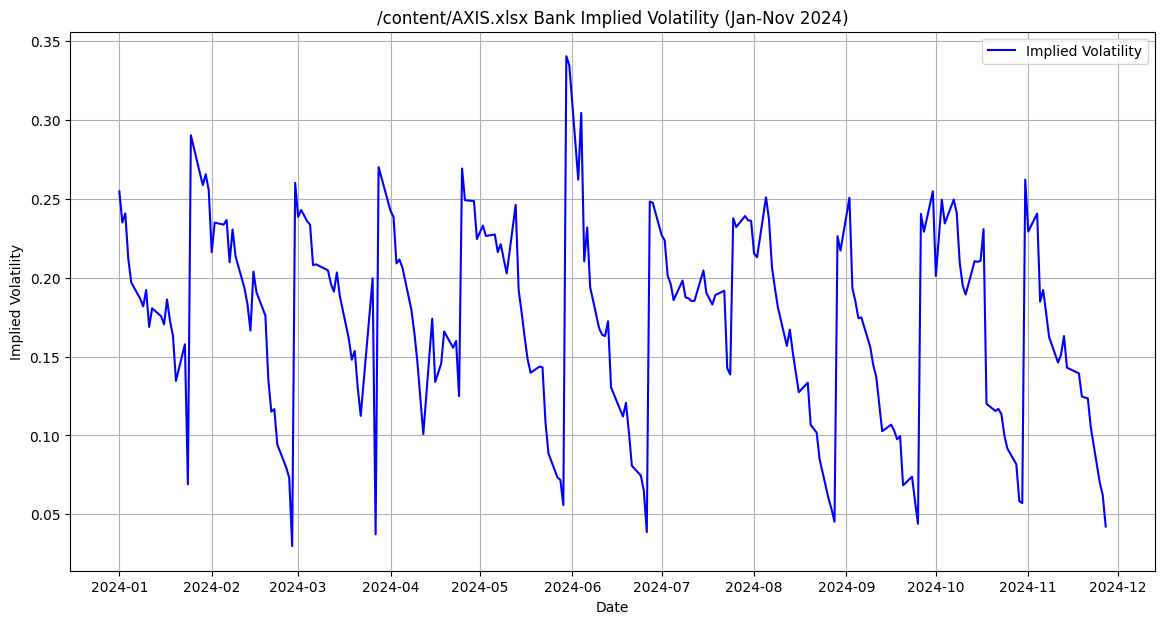

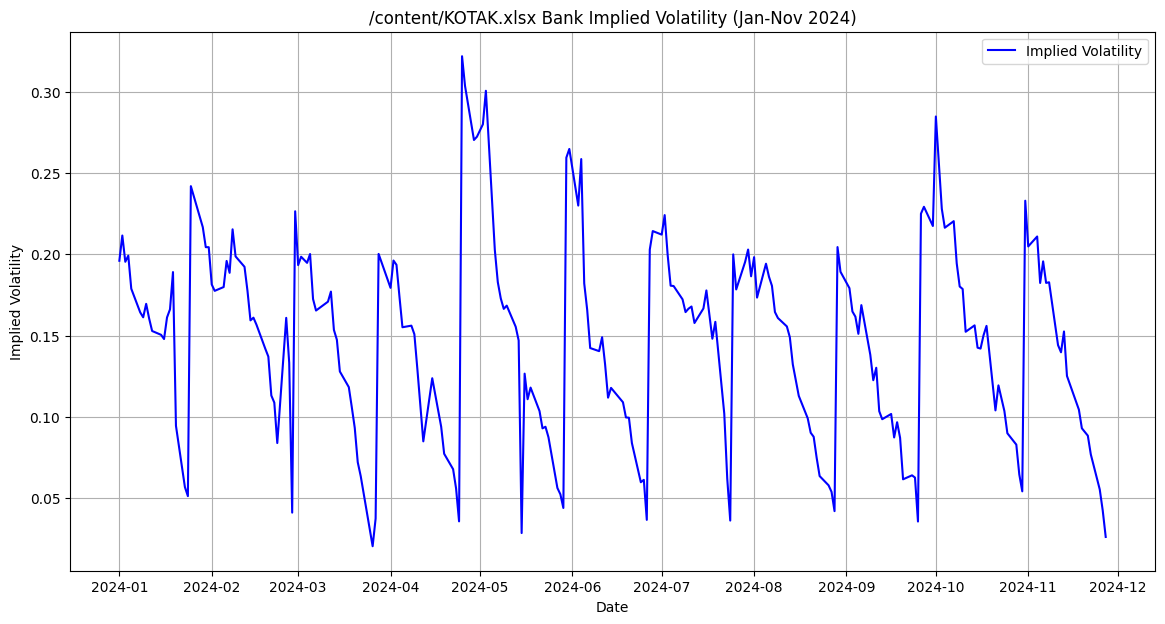

In [ ]:
for symbol, data in bank_data.items():
  data['Implied_Volatility'] = data.apply(
    lambda row: implied_vol(
        S0=row['Underlying Value'],
        K=row['Strike Price'],
        T=row['T'],
        r=0.07365,
        market_price=row['Close']
    ),
    axis=1
  )
  plt.figure(figsize=(14, 7))
  plt.plot(data['Date'], data['Implied_Volatility'], label='Implied Volatility', color='blue')
  plt.title(f"{symbol} Bank Implied Volatility (Jan-Nov 2024)")
  plt.xlabel('Date')
  plt.ylabel('Implied Volatility')
  plt.legend()
  plt.grid(True)
  plt.show()

In [ ]:
market_caps = {}
for symbol in bank_symbols:
    ticker = yf.Ticker(symbol)
    market_caps[symbol] = ticker.info['marketCap']

total_market_cap = sum(market_caps.values())
weights = {symbol: market_cap / total_market_cap for symbol, market_cap in market_caps.items()}
weights = {
    '/content/SBI.xlsx': weights['SBIN.NS'],
    '/content/HDFC.xlsx': weights['HDFCBANK.NS'],
    '/content/ICICI.xlsx': weights['ICICIBANK.NS'],
    '/content/AXIS.xlsx': weights['AXISBANK.NS'],
    '/content/KOTAK.xlsx': weights['KOTAKBANK.NS']
}
print(weights)

{'/content/SBI.xlsx': 0.1925910736637662, '/content/HDFC.xlsx': 0.36591664062740414, '/content/ICICI.xlsx': 0.24759276190805174, '/content/AXIS.xlsx': 0.08515005335362795, '/content/KOTAK.xlsx': 0.10874947044714998}


In [ ]:
all_bank_data = pd.concat(bank_data.values(), keys=bank_data.keys())
all_bank_data = all_bank_data.reset_index(level=0).rename(columns={'level_0': 'Bank'})
all_bank_data = all_bank_data[['Date', 'Bank', 'Implied_Volatility']]
print(all_bank_data)

            Date                 Bank  Implied_Volatility
37    2024-01-01    /content/SBI.xlsx            0.280403
97    2024-01-02    /content/SBI.xlsx            0.276025
158   2024-01-03    /content/SBI.xlsx            0.262854
218   2024-01-04    /content/SBI.xlsx            0.256084
277   2024-01-05    /content/SBI.xlsx            0.231562
...          ...                  ...                 ...
10201 2024-11-21  /content/KOTAK.xlsx            0.088368
10235 2024-11-22  /content/KOTAK.xlsx            0.076850
10270 2024-11-25  /content/KOTAK.xlsx            0.055273
10302 2024-11-26  /content/KOTAK.xlsx            0.042307
10336 2024-11-27  /content/KOTAK.xlsx            0.026033

[1130 rows x 3 columns]


In [ ]:
daily_avg_volatility = all_bank_data.groupby('Date').apply(
    lambda group: np.average(group['Implied_Volatility'], weights=[weights.get(bank, 0) for bank in group['Bank']])).reset_index(name='Implied_Volatility')
print(daily_avg_volatility)
daily_avg_volatility['Annualized_Volatility'] = daily_avg_volatility['Implied_Volatility'] * np.sqrt(252)
base_date = daily_avg_volatility['Date'].min()
base_volatility = daily_avg_volatility.loc[daily_avg_volatility['Date'] == base_date, 'Annualized_Volatility'].values[0]
daily_avg_volatility['Index'] = 100 * (daily_avg_volatility['Annualized_Volatility'] / base_volatility)

          Date  Implied_Volatility
0   2024-01-01            0.227090
1   2024-01-02            0.218480
2   2024-01-03            0.213530
3   2024-01-04            0.205435
4   2024-01-05            0.190455
..         ...                 ...
221 2024-11-21            0.102458
222 2024-11-22            0.083204
223 2024-11-25            0.065701
224 2024-11-26            0.052545
225 2024-11-27            0.042023

[226 rows x 2 columns]


<ipython-input-11-a0fe08538675>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_avg_volatility = all_bank_data.groupby('Date').apply(


for returns in returns_data:
  # Step 3: Split Data for Model Estimation
  split_index = int(len(returns) * 0.8)
  train_returns = returns[:split_index]
  test_returns = returns[split_index:]

  # Estimate parameters using training data
  initial_params = [0.000001, 0.05, 0.90]
  result = minimize(garch_likelihood, initial_params, args=(train_returns, time,), constraints=constraints)

  # Extract optimized parameters
  omega, alpha, beta = result.x

  print("Estimated Parameters:")
  print(f"Omega: {omega}")
  print(f"Alpha: {alpha}")
  print(f"Beta: {beta}")

  # Step 4: Forecast Future Volatility
  n_forecast = 90  # Forecast for next 30 days
  forecasted_volatility=[]

  # Initialize variance with last observed variance from the full dataset
  var = np.var(returns.values)
  last_return = returns.iloc[-1]

  for i in range(n_forecast):
      # Forecast variance
      var = omega + alpha * last_return**2 + beta * var
      forecasted_volatility.append(np.sqrt(var))
      
      # Simulate next return (assuming normal distribution)
      simulated_return = np.random.normal(0, np.sqrt(var))
      last_return = simulated_return

  # Step 5: Simulate Future Returns
  forecasted_volatility = np.array(forecasted_volatility)
  forecasted_returns = np.random.normal(0, forecasted_volatility)

  # Step 6: Plot Results
  plt.figure(figsize=(12, 6))
  plt.plot(forecasted_volatility, label='Forecasted Volatility', color='blue')
  plt.title("Forecasted Volatility for Next 90 Days (GARCH(1,1))")
  plt.xlabel("Days")
  plt.ylabel("Volatility")
  plt.grid(True)
  plt.legend()
  plt.show()

  plt.figure(figsize=(12, 6))
  plt.plot(forecasted_returns, label='Forecasted Returns', color='green')
  plt.title("Forecasted Returns for Next 90 Days (GARCH(1,1))")
  plt.xlabel("Days")
  plt.ylabel("Returns")
  plt.grid(True)
  plt.legend()
  plt.show()

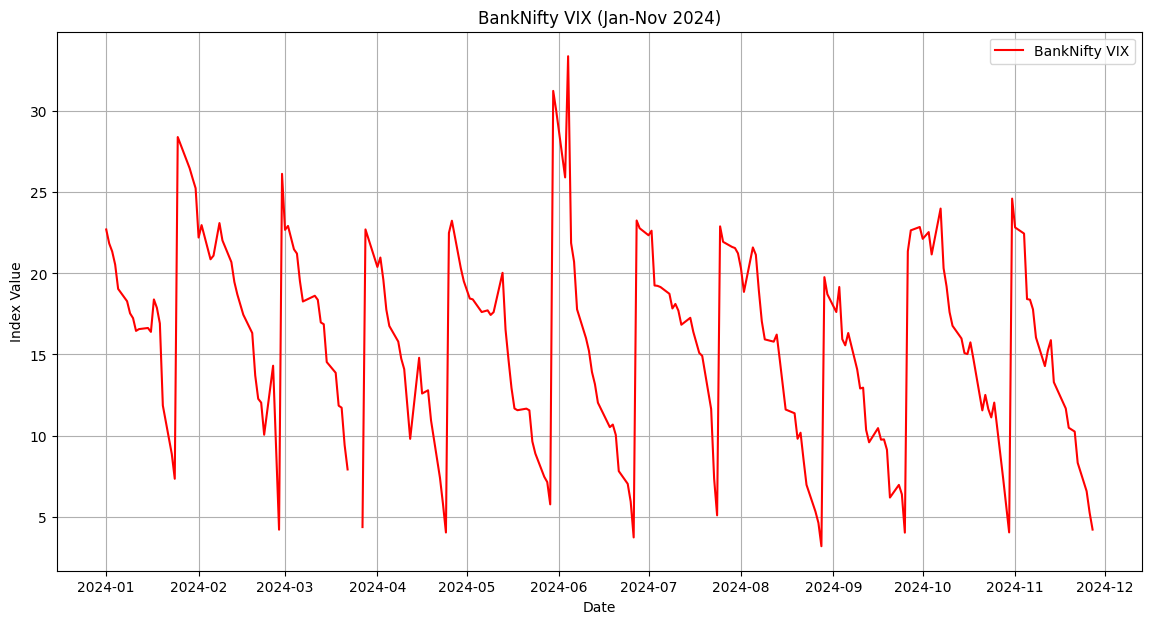

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(daily_avg_volatility['Date'], daily_avg_volatility['Implied_Volatility'] * 100, label='BankNifty VIX', color='red')
plt.title('BankNifty VIX (Jan-Nov 2024)')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
from google.colab import files
uploaded = files.upload()

# Move the uploaded files to the /content/ directory
for filename in uploaded.keys():
    !mv "$filename" "/content/$filename"